## New York City public schools
The dataset we'll be using can be downloaded at [New York City public schools](https://data.cityofnewyork.us/browse?category=Education).

#### Scholastic Aptitude Test (SAT) Controversies
The SAT, or Scholastic Aptitude Test, is an exam that U.S. high school students take before applying to college. The SAT has three sections, each is worth **800** points. Colleges take the test scores into account when deciding who to admit, so it's important to perform well.

One of the most controversial issues in the U.S. educational system is the **efficacy of standardized tests and whether they're unfair to certain groups**. Given our prior knowledge of this topic, investigating the **correlations between SAT scores and demographics** might be an interesting angle to take. We could **correlate SAT scores with factors like race, gender, income**, and more.

New York City makes its data on [high school SAT scores](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) available online, as well as the [demographics for each high school](https://data.cityofnewyork.us/Education/DOE-High-School-Directory-2014-2015/n3p6-zve2). 

The same website has several related datasets covering demographic information and test scores. 

**All the interrelated datasets have collected, cleaned and combined into a single dataset `nyc_high_schools.csv` ready for analysis. See notebook `Data_Cleaning_Walkthrough_NYC_public_schools`**.

See [notebook on Github](https://github.com/dataquestio/solutions/blob/master/Mission217Solutions.ipynb) that contains the solutions.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from glob import glob
%matplotlib inline

### Load the cleaned and combined data

In [2]:
combined = pd.read_csv('./data_clean/nyc_high_schools.csv')
print(combined.shape)
combined.head()

(363, 160)


,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,1
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,1
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,1
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,1
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,1


In [3]:
z = combined.isnull().sum()
print(f'Columns with missing values:\n{z[z > 0]}')

Columns with missing values:
Series([], dtype: int64)


In [4]:
combined.dtypes

DBN                                 object
SCHOOL NAME                         object
Num of SAT Test Takers              object
SAT Critical Reading Avg. Score    float64
SAT Math Avg. Score                float64
                                    ...   
priority10                           int64
Location 1                          object
lat                                float64
lon                                float64
school_dist                          int64
Length: 160, dtype: object

## Analyzing and Visualizing the Data
### Finding Correlations 
We'll find any **correlations between columns and `sat_score`**. This helps us determine which columns might be interesting to plot out or investigate further.

In [5]:
correlations = combined.corr(numeric_only = True)
correlations = correlations.loc[:, 'sat_score']
correlations

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
school_dist                        0.042948
Name: sat_score, Length: 71, dtype: float64

Unsurprisingly, `SAT Critical Reading Avg. Score`, `SAT Math Avg. Score` and `SAT Writing Avg. Score` are strongly correlated with `sat_score`.

We can also make some other observations:

* `total_enrollment` has a strong positive correlation with `sat_score`. This is surprising because we'd expect smaller schools where students receive more attention to have higher scores. However, it looks like the opposite is true -- larger schools tend to do better on the SAT.
    * Other columns that are proxies for enrollment correlate similarly. These include total_students, `N_s`, `N_p`, `N_t`, `AP Test Takers`, `Total Exams Taken`, and `NUMBER OF SECTIONS`.
* Both the percentage of females (`female_per`) and number of females (`female_num`) at a school **correlate positively** with SAT score, whereas the percentage of males (`male_per`) and the number of males (`male_num`) **correlate negatively**. This could indicate that *female candidates do better on the SAT thir male counterpart*.
* Teacher and student ratings of school safety (`saf_t_11`, and `saf_s_11`) correlate with `sat_score`.
* Student ratings of school academic standards (`aca_s_11`) correlate with `sat_score`, but this does not hold for ratings from teachers and parents (`aca_p_11` and `aca_t_11`).
* There is significant racial inequality in SAT scores (`white_per`, `asian_per`, `black_per`, `hispanic_per`).
* The percentage of students eligible for free or reduced school lunch based on household income (`frl_percent`) has a **strong negative correlation** with SAT scores.

Since **enrollment seems to have such a strong correlation**, let's make a scatterplot of `total_enrollment` vs `sat_score`. Each point in the scatterplot represents a high school, so we'll be able to see if there are any interesting patterns.

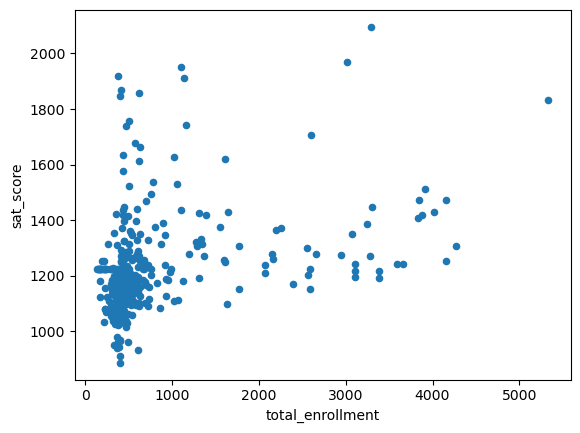

In [6]:
combined.plot.scatter(x = 'total_enrollment', y = 'sat_score')
plt.show()

Judging from the plot, it doesn't appear there's a *strong correlation between `sat_score` and `total_enrollment`*.
However, there's an **interesting cluster of points at the bottom left** where `total_enrollment` and `sat_score` are both low. This cluster may be what's making the r value so high. It's worth extracting the names of the schools in this cluster so we can research them further.

### Exploring Schools with Low SAT Scores and Enrollment

In [7]:
low_enrollment = combined.loc[(combined.total_enrollment < 1000) & (combined.sat_score < 1000), :]
low_enrollment['School Name']

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
125                                        0
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
179            HIGH SCHOOL OF WORLD CULTURES
188       BROOKLYN INTERNATIONAL HIGH SCHOOL
225    INTERNATIONAL HIGH SCHOOL AT PROSPECT
237               IT TAKES A VILLAGE ACADEMY
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object

### Plotting Language Learning Percentage
Our research revealed that **most of the high schools with low total enrollment and low SAT scores have high percentages of English language learners**. This indicates that it's actually **`ell_percent` that correlates strongly with `sat_score`**, rather than `total_enrollment`.

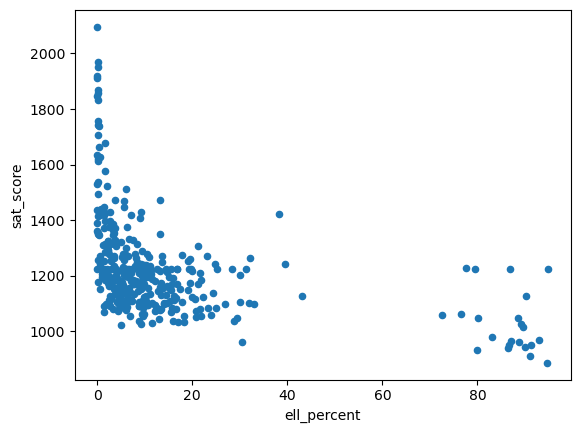

In [8]:
combined.plot.scatter(x = 'ell_percent', y = 'sat_score')
plt.show()

### Calculating District-Level Statistics
We are going to **aggregate by district**, which enables us to understand how **`ell_percent` varies district-by-district** instead of the unintelligibly granular school-by-school variation.

In [9]:
districts = combined.groupby('school_dist').mean(numeric_only = True)
districts.reset_index(inplace = True)
districts.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Cohort,Total Cohort,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,1,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,2006.000000,93.500000,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,2,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,1713.458333,158.647849,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,3,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,1504.500000,183.384409,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,4,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,2006.000000,113.857143,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,5,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,1432.857143,143.677419,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


## Guided Project Section: Analyzing NYC High School Data
### Find correlations

In [10]:
correlations = combined.corr(numeric_only = True)
correlations = correlations['sat_score']
correlations

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
school_dist                        0.042948
Name: sat_score, Length: 71, dtype: float64

### Plotting survey correlations

In [12]:
survey_fields = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", 
                 "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", 
                 "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]

In [13]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove('DBN')

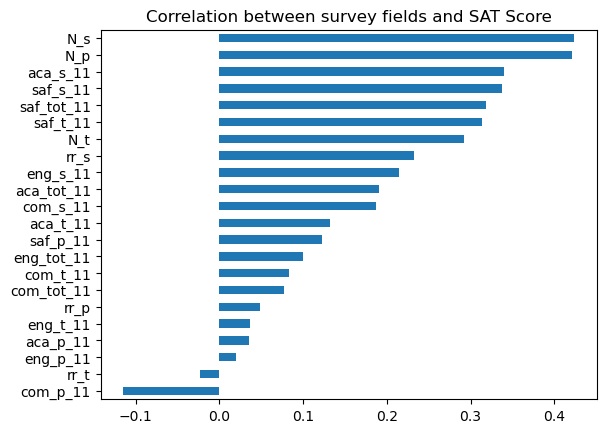

In [14]:
correlations[survey_fields].sort_values().plot(kind = 'barh')
plt.title('Correlation between survey fields and SAT Score');

In [15]:
correlations.head(10)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Cohort                                  0.021102
Total Cohort                            0.325144
CSD                                     0.042948
Name: sat_score, dtype: float64

In [16]:
correlations.tail(10)

expgrade_span_max         NaN
zip                 -0.063977
total_students       0.407827
number_programs      0.117012
priority08                NaN
priority09                NaN
priority10                NaN
lat                 -0.121029
lon                 -0.132222
school_dist          0.042948
Name: sat_score, dtype: float64

We can also make some other observations:

* `total_students` has a strong positive correlation (`0.407827`) with `sat_score`. This is surprising because we'd expect smaller schools where students receive more attention to have higher scores. However, it looks like the opposite is true -- larger schools tend to do better on the SAT.
    * Other columns that are proxies for enrollment correlate similarly. These include `N_s`, `N_p`, `N_t`, `AP Test Takers`, `Total Exams Taken`, and `NUMBER OF SECTIONS`.
* Teacher and student ratings of school safety (`saf_t_11`, and `saf_s_11`) correlate fairly with `sat_score`.
* Student ratings of school academic standards (`aca_s_11`) correlate with `sat_score`, but this does not hold for ratings from teachers and parents (`aca_p_11` and `aca_t_11`) with not so strong correlation with `sat_score`.

### Exploring Safety and SAT Scores

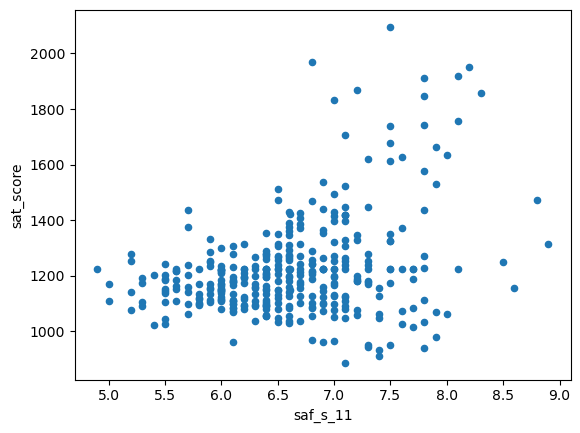

In [17]:
combined.plot(x = 'saf_s_11', y = 'sat_score', kind = 'scatter');

In [18]:
correlations['saf_s_11'], correlations['saf_t_11']

(0.33763874436088115, 0.3138103333520099)

Teacher and student ratings of school safety (`saf_t_11`, and `saf_s_11`) correlate fairly with `sat_score`.
### Total Safety by Borough

In [19]:
safety = combined.groupby('DBN').saf_tot_11.mean().sort_values(ascending = False)
safety.head(10)

DBN
32K554    9.3
10X696    8.7
24Q530    8.6
31R605    8.6
02M439    8.6
02M427    8.6
26Q430    8.6
02M416    8.5
14K685    8.5
01M696    8.5
Name: saf_tot_11, dtype: float64

### Top 10 Safe Boroughs

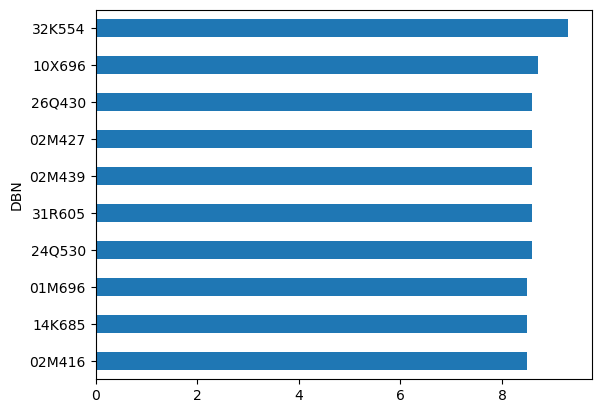

In [20]:
top10_safety = safety.head(10)
top10_safety.sort_values().plot(kind = 'barh');

### Bottom 10 Safe Boroughs

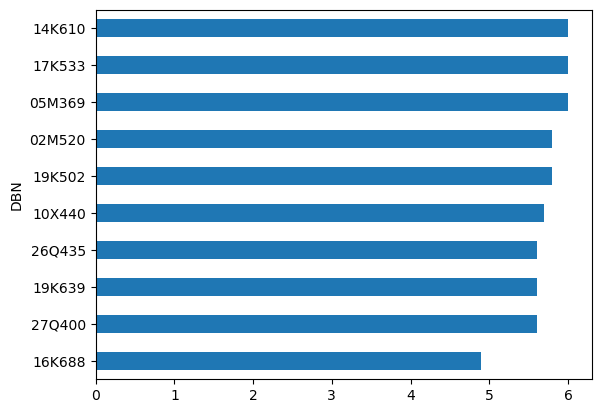

In [21]:
bottom10_safety = safety.tail(10)
bottom10_safety.sort_values().plot(kind = 'barh');

## Exploring Race and SAT Scores
Few columns that indicate the percentage of each race at a given school are:
* `white_per`
* `asian_per`
* `black_per`
* `hispanic_per`

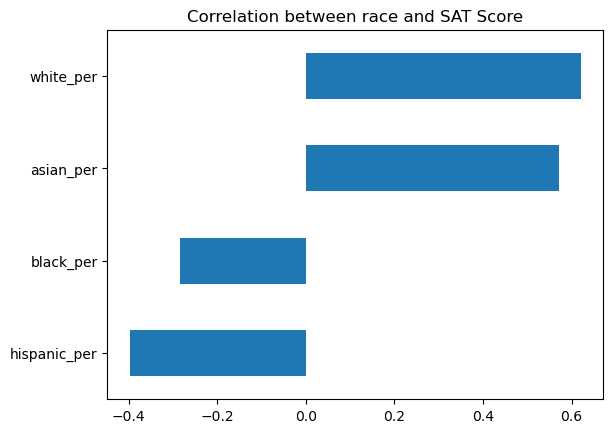

In [22]:
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

correlations[race_cols].sort_values().plot(kind = 'barh')
plt.title('Correlation between race and SAT Score');

**Students from `white`and `asian` backgrounds seem to perform well in SAT than their counterparts from `black`and `hispanic` backgrounds**.

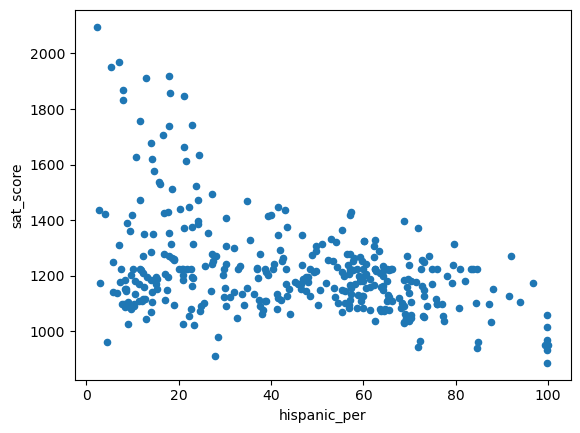

In [23]:
combined.plot(x = 'hispanic_per', y = 'sat_score', kind = 'scatter');

**The SAT scores are high when the percentage of hsipanic students is low and low when the percentage of hsipanic students is high**! The SAT remains fairly constant from about 25% and above of hispanic students.

In [24]:
hispanic_95 = combined.loc[combined.hispanic_per > 95]
hispanic_95['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

### MANHATTAN BRIDGES HIGH SCHOOL
#### [Overview](https://www.myschools.nyc/en/schools/high-school/02M542/)
We are a college prep school founded on the belief that mastery of communication skills in both English and a students' home language is key to realizing a student's potential in a multicultural society.

#### [Mission Statement](https://sites.google.com/manhattanbridgeshs.org/mbhs/History-of-the-school/mission-statement)
We provide access to academically challenging college preparatory coursework in Humanities, Science, Technology, Engineering, and Math (STEM) to all of our Latino English Language Learners (ELLs).  This is done so that students can meet the demands of the 21st century global economy. We focus on developing students' skills in bilingual academic language, communication, and career readiness. We empower students to use their native cultures and language as a personal and professional asset.

### WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
#### [Overview](https://www.myschools.nyc/en/schools/high-school/06M348/)
Our mission is to work with families to prepare each student academically, emotionally, intellectually, and socially to succeed in the college of their choice and beyond. We provide a small, nurturing environment where high expectations, excellent instruction, and dedicated faculty work relentlessly to meet the needs of all students.

#### [Mission Statement](https://www.wheelsnyc.org/mission)
The mission of WHEELS is to collaborate with families to prepare each pre-K through twelfth-grade student academically, emotionally, intellectually, and socially to succeed in a post-secondary institution of their choice and beyond.

In [25]:
hispanic_10_1800 = combined.loc[(combined.hispanic_per < 10) & (combined.sat_score > 1800)]
hispanic_10_1800['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

### STUYVESANT HIGH SCHOOL
#### [Overview](https://www.myschools.nyc/en/schools/high-school/02M475/)
Stuyvesant High School's mission is to provide students with a rigorous curriculum that nurtures and rewards their intellectual curiosity. Although Stuyvesant is historically recognized for its strengths in math, science, and technology instruction, the school also has a dynamic and diverse humanities program, as well as unique educational opportunities outside the classroom.

Stuyvesant High School has been a symbol of excellence in education for over a century. We honor this commitment by providing an environment that will nurture and elevate the special academic talents of our student body. While Stuyvesant is deeply rooted in the tradition of science, mathematics, and technology, which remains a cornerstone of our educational program and success, the overall mission of our institution is to instill the intellectual, moral, and humanistic values necessary for each young adult to achieve their maximum potential as a student and as a caring citizen of the world.

#### [MISSION STATEMENT](https://stuy.enschool.org/apps/pages/index.jsp?uREC_ID=126631&type=d&pREC_ID=251661&hideMenu=1)
Stuyvesant High School is a highly diverse community of cultures, languages, and countries of origin. Our diversity is our strength and we are committed to cultivating an inclusive environment, where every member of our school community is recognized and feels relevant. We continue to create the conditions for intellectual and social development for all members and the various identities (gender, sexuality, race, ethnicity, and religion) they bring to our community. Everyone should feel safe and respected, and we strive to facilitate opportunities

for meaningful experiences rooted in openness and empathy. Finally, we strive in our continuous improvement of our policies, practices, and pedagogy to create an educational environment that is non-discriminatory and anti-racist.

### BRONX HIGH SCHOOL OF SCIENCE
#### [History](https://www.bxscience.edu/apps/pages/index.jsp?uREC_ID=219378&type=d&termREC_ID=&pREC_ID=433038&hideMenu=0)
The Bronx High School of Science was founded in 1938 by resolution of the Department of Education of the City of New York with Dr. Morris Meister as the first principal of the school.  The school was housed in a Gothic building located at Creston Avenue and 184th Street. The building, built in 1918 for Evander Childs High School, was previously occupied by Walton High School (1930) and by an annex of DeWitt Clinton High School (1935). Bronx Science started with 150 ninth grade students and 250 tenth grade students, and the remaining facilities were used by DeWitt Clinton. As Bronx Science became larger, the Clinton contingent was gradually returned to its main building. During their joint occupation, which lasted for two years, the two schools had separate teaching staff and classes, but the same supervision and administration.

#### [MISSION](https://www.bxscience.edu/apps/pages/index.jsp?uREC_ID=219379&type=d&termREC_ID=&pREC_ID=433043&hideMenu=0)
Frequently cited as the most renowned high school in America, the Bronx High School of Science attracts an intellectually gifted blend of culturally, ethnically and economically diverse students. Scienceites, as the school's students are known, are supported by an actively involved Parents' Association, Alumni Foundation, and a core of skilled teachers who excel at their craft. Our students are proud of their school's alumni, who include nine Nobel Prize winners, the first African-American neurosurgeon, countless authors, lawyers, physicians, educators, artists, entertainers and leaders in business and government.

## Exploring Gender and SAT Scores
There are two columns that indicate the percentage of each gender at a school:

* `male_per`
* `female_per`
We can plot out the correlations between each percentage and `sat_score`.

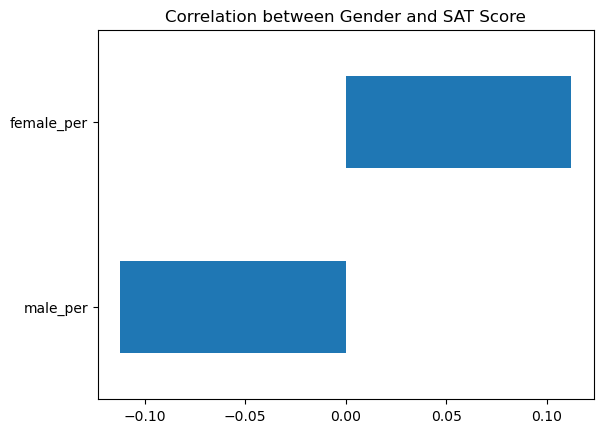

In [26]:
gender_cols = ['male_per', 'female_per']
correlations[gender_cols].sort_values().plot(kind = 'barh')
plt.title('Correlation between Gender and SAT Score');

**Female gender seems to correlate positively (albeit a very weak correlation) with SAT score while Male correlates negatively. This means as the number of female students increase SAT score also increases. This is the reverse with male students.**

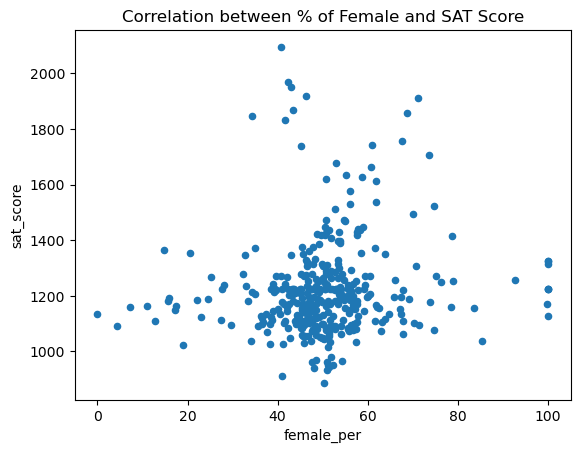

In [27]:
combined.plot(x = 'female_per', y = 'sat_score', kind = 'scatter')
plt.title('Correlation between % of Female and SAT Score');

**A fairly positive correlation around 60% and above..**

In [28]:
female_60_1700 = combined.loc[(combined.female_per > 60) & (combined.sat_score > 1700)]
female_60_1700['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

## BARD HIGH SCHOOL EARLY COLLEGE
#### [Mission](https://bhsec.bard.edu/mission-theory-of-change/)
Bard Early College seeks to improve the transition from high school to college and increase access and success in higher education. We do this by offering high school-age students, particularly those from low-income and historically underrepresented communities, a tuition-free college program of study in the liberal arts and sciences, and by working to influence and lead a national movement for early college education focused on quality and equity.

## ELEANOR ROOSEVELT HIGH SCHOOL
#### [Mission](https://www.erhsnyc.org/apps/pages/index.jsp?uREC_ID=27739&type=d&pREC_ID=1064872)
At Eleanor Roosevelt High School, our community of students, faculty, staff, administrators, and families thrive in a diverse, collaborative, and supportive environment. We strive to be empathetic, active, and reflective listeners as we advocate for ourselves and each other. Our educational priorities are to provide rigor and encourage curiosity in all academic disciplines, including the infusion of artistic elements. Our mission is to create a foundation for students to become life-long learners who are critical thinkers, effective communicators, and creative problem solvers.

## Exploring AP Scores vs. SAT Scores

In [29]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

In [30]:
combined['ap_per'].corr(combined['sat_score'])

0.0571708139076697

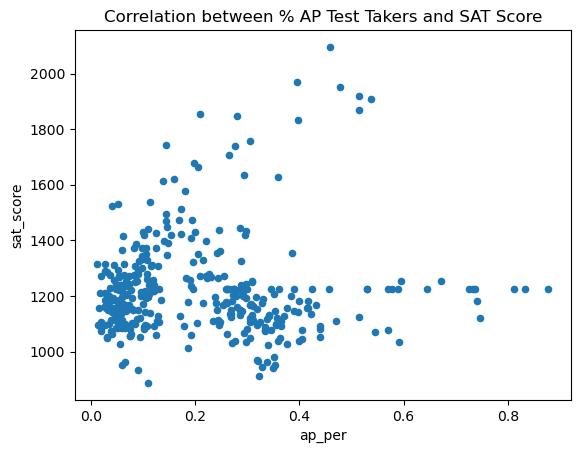

In [31]:
combined.plot(x = 'ap_per', y = 'sat_score', kind = 'scatter')
plt.title('Correlation between % AP Test Takers and SAT Score');

**The Correlation between % AP Test Takers and SAT Score is surprisingly very weak!** This means that the proportion of student who sit for AP exams does not noticeably increase as the SAT scores.  